# Climate-Friendly Food Systems (CFFS) Labelling Project

### The University of British Columbia

***

## Part V: Labelling Recipes

## Set up and Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import os
from configparser import ConfigParser

In [2]:
# RUN ONLY ONCE
# os.chdir is used to change the current directory to the specified path
os.chdir("../") # Sets path to the repo folder as it is one level above where this file exists!
path = os.getcwd()
print(path)

/Users/vivaanwadhwa/Documents/GitHub/CFFS_sharon_2024


## Set Baselines

In [3]:
config = ConfigParser()
config.read("data/Misc/data_for_calculating_baseline/baseline.ini")

overall_baseline = float(config["baseline"]["GHG_baseline"])
fifty_cutoff = overall_baseline/2

GHG_baseline = float(config["baseline"]["GHG_baseline"])
nitrogen_baseline = float(config["baseline"]["nitrogen_baseline"])
water_baseline = float(config["baseline"]["water_baseline"])
land_baseline = float(config["baseline"]["land_baseline"])
print(GHG_baseline,nitrogen_baseline,water_baseline,land_baseline)

364.61114734025256 4.428944853430558 1320.569404551064 0.8534548672606304


In [4]:
restaurant_name = "AMS_Gallery24"

In [5]:
def create_ghg_label(label):
    # determine the GHG label based on the given label value and predefined cutoffs
    if label > overall_baseline:
        # if the label value is > than overall baseline, assign "Red" label
        return "Red"
    elif (label <= overall_baseline) & (label > fifty_cutoff):
        # if the label value is between overall baseline and fifty_cutoff, assign "Yellow" label
        return "Yellow"
    elif label <= fifty_cutoff:
        # if the label value is less than or equal to the fifty_cutoff, assign "Green" label
        return "Green"


In [6]:
def create_results_all_factors(df):
    # create a Combined Label based on different factors for each row in the DataFrame
    df["Combined Label"] = ""

    # add another parameter: n so that change the number of factors instead of multiplying by 3

    def calculate_all_factors(ghg, nitrogen, water, land):
        # calculate the combined label value based on the given factors
        weighted_ghg = ghg / (4 * GHG_baseline)
        weighted_nitrogen = nitrogen / (4 * nitrogen_baseline)
        weighted_water = water / (4 * water_baseline)

        # most recently added
        weighted_land = land / (4 * land_baseline)
        return weighted_ghg + weighted_nitrogen + weighted_water + weighted_land


    for ind, row in df.iterrows():
        # iterate over each row in the DataFrame and calculate the combined label
        label = calculate_all_factors(row["GHG Emission (g) / 100g"], row["N lost (g) / 100g"],
                                      row["Stress-Weighted Water Use (L) / 100g"],
                                      row['Land Use (m^2) / 100g'])
        if label <= 0.5:
            # if the label value is less than or equal to 0.5, assign "Green" label
            df.loc[ind, "Combined Label"] = "Green"
        elif label >= 1:
            # if the label value is greater than or equal to 1, assign "Red" label
            df.loc[ind, "Combined Label"] = "Red"
        elif (label > 0.5) or (label < 1):
            # if the label value is between 0.5 and 1, assign "Yellow" label
            df.loc[ind, "Combined Label"] = "Yellow"
    return df


In [7]:
# Fixes KeyError: 1
def add_menu_names(df, mapping_dict):
    # Add menu names to the DataFrame based on a dictionary
    df["Displayed Name"] = ""
    menu_name = list(mapping_dict.keys())
    menu_ID = list(mapping_dict.values())
    for ind, row in df.iterrows():
        searchID = row["ProdId"]
        if searchID in menu_ID:
            position = menu_ID.index(searchID)
            name = menu_name[position]
            df.at[ind, "Displayed Name"] = name

    name_col = df.pop("Displayed Name")
    df.insert(0, "Displayed Name", name_col)
    df = df.dropna(subset=["Displayed Name"])

    df_temp = df["Displayed Name"].str.split("|", expand=True)
    df["Category"] = df_temp[0]

    # Ensure that 'Displayed Name' is updated only if there is a second column
    if len(df_temp.columns) > 1:
        df["Displayed Name"] = df_temp[1]
    else:
        df["Displayed Name"] = ""

    name_col2 = df.pop("Category")
    df.insert(0, "Category", name_col2)
    return df

In [8]:
def create_final_counts(df):
    # create final counts of GHG and combined labels from DataFrame

    # count the occurrences of GHG Only labels
    ghg_red = df["GHG Only Label"].value_counts()["Red"]
    ghg_yellow = df["GHG Only Label"].value_counts()["Yellow"]
    ghg_green = df["GHG Only Label"].value_counts()["Green"]
    # count the occurrences of Combined labels
    all_red = df["Combined Label"].value_counts()["Red"]
    all_yellow = df["Combined Label"].value_counts()["Yellow"]
    all_green = df["Combined Label"].value_counts()["Green"]
    print(all_red, all_yellow, all_green)
    # create a dictionary to store the label counts
    data = {"GHG Label Counts": [ghg_red, ghg_yellow, ghg_green],
            "Combined Label Counts": [all_red, all_yellow, all_green]}
    # create a DataFrame from the label counts data and return it
    results = pd.DataFrame(data, index=["Red", "Yellow", "Green"])
    return results


In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

def create_visualizations(df):
    # Check if 'Color' column exists, if not, create it from the DataFrame's index
    if 'Color' not in df.columns:
        df = df.reset_index().rename(columns={'index': 'Color'})
    
    # Set the seaborn theme
    sns.set_theme(style="darkgrid")
    
    # Define the custom color palette
    palette = {"Green": "tab:green", "Red": "tab:red", "Yellow": "tab:orange", "Sum": "tab:blue"}
    
    # Create the subplot structure
    fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharex=False, sharey=True)
    
    # Overall figure title
    fig.suptitle("Emission Label Counts", fontsize=16)
    
    # Plotting GHG Emission Label counts
    ax1 = sns.barplot(data=df, x="Color", y="GHG Label Counts", ax=axes[0], palette=palette)
    ax1.set_title("GHG Emission Label")  # Set the title for the first plot
    ax1.set_ylabel("Counts")  # Set the Y-axis label for the first plot
    ax1.set_xlabel("Color")  # Optionally set the X-axis label
    
    # Plotting Combined Emissions Label counts
    ax2 = sns.barplot(data=df, x="Color", y="Combined Label Counts", ax=axes[1], palette=palette)
    ax2.set_title("Combined Emissions Label")  # Set the title for the second plot
    ax2.set_ylabel("")  # Optionally clear the Y-axis label for the second plot for aesthetics
    ax2.set_xlabel("Color")  # Optionally set the X-axis label
    
    # Add labels to the bars in both plots
    for ax in [ax1, ax2]:
        for container in ax.containers:
            ax.bar_label(container, label_type='edge')  # Add the counts above the bars
    
    # Adjust layout for a tight fit and to prevent label overlap
    plt.tight_layout()
    
    # Save the figure to file
    plt.savefig(os.getcwd() + "/data/final/2023_2024_CFFS_Outcomes/AMS_Summary_fig.png")
    
    # Display the plot
    plt.show()


In [10]:
def create_category_true(df):
    # create category columns for True values in the DataFrame

    # create empty columns for each category
    df["RED"] = ""
    df["YELLOW"] = ""
    df["GREEN"] = ""
    # iterate over each row in the DataFrame
    for ind, row in df.iterrows():
        # Check the value of the Combined Label column and assign "TRUE" to the corresponding category column
        if row["Combined Label"] == "Red":
            df.loc[ind, "RED"] = "TRUE"
        if row["Combined Label"] == "Yellow":
            df.loc[ind, "YELLOW"] = "TRUE"
        if row["Combined Label"] == "Green":
            df.loc[ind, "GREEN"] = "TRUE"
    # adds category columns for True values based on the Combined Label column
    return df


In [11]:
products = pd.read_csv("data/final/AMS_2024_footprints/Recipes Footprints.csv")

In [12]:
final = products.copy()
final

,ProdId,Description,SalesGroup,Weight (g),GHG Emission (g),N lost (g),Land Use (m^2),Freshwater Withdrawals (L),Stress-Weighted Water Use (L),GHG Emission (g) / 100g,N lost (g) / 100g,Freshwater Withdrawals (L) / 100g,Stress-Weighted Water Use (L) / 100g,Land Use (m^2) / 100g
0,R-7227,2024S Beets Salad,Y,437.598000,611.503237,7.404834,0.840871,89.25,4784.22,139.74,1.69,20.40,1093.29,0.19
1,R-3664,2024S Poutine,Y,705.900000,1047.893633,9.528025,1.866057,126.21,6504.84,148.45,1.35,17.88,921.50,0.26
2,R-7065,2024S Power Punch,Y,416.730000,472.456864,3.194144,1.619137,84.43,3031.46,113.37,0.77,20.26,727.44,0.39
3,R-14987,2024S Truffle Fries,Y,403.750000,489.355148,4.104747,1.033670,40.97,2114.90,121.20,1.02,10.15,523.81,0.26
4,R-18272,2024S Truffle Mushroom Pasta,Y,930.548400,1183.710674,10.604007,3.062520,241.45,8853.32,127.21,1.14,25.95,951.41,0.33
5,R-4432,2024S Tuscan penne,Y,595.709160,672.830332,3.370630,1.408591,150.50,8291.26,112.95,0.57,25.26,1391.83,0.24
6,R-15057,2024S Vegan Burger,Y,529.708800,555.521602,3.771200,2.483040,36.33,1248.50,104.87,0.71,6.86,235.70,0.47
7,R-16782,2024S Vegan Caesar (Salad),Y,564.000000,629.687316,4.843406,2.120515,72.72,4077.43,111.65,0.86,12.89,722.95,0.38
8,R-3677,2024S Yam Fries,Y,437.100000,258.253290,2.020290,0.683019,1.13,34.29,59.08,0.46,0.26,7.84,0.16
9,R-8573,2024S Yellow Thai (Tempeh),Y,868.740000,527.460542,3.390929,1.715334,10.53,313.61,60.72,0.39,1.21,36.10,0.20


In [13]:
final["GHG Only Label"] = final["GHG Emission (g) / 100g"].apply(lambda x: create_ghg_label(x))
final

,ProdId,Description,SalesGroup,Weight (g),GHG Emission (g),N lost (g),Land Use (m^2),Freshwater Withdrawals (L),Stress-Weighted Water Use (L),GHG Emission (g) / 100g,N lost (g) / 100g,Freshwater Withdrawals (L) / 100g,Stress-Weighted Water Use (L) / 100g,Land Use (m^2) / 100g,GHG Only Label
0,R-7227,2024S Beets Salad,Y,437.598000,611.503237,7.404834,0.840871,89.25,4784.22,139.74,1.69,20.40,1093.29,0.19,Green
1,R-3664,2024S Poutine,Y,705.900000,1047.893633,9.528025,1.866057,126.21,6504.84,148.45,1.35,17.88,921.50,0.26,Green
2,R-7065,2024S Power Punch,Y,416.730000,472.456864,3.194144,1.619137,84.43,3031.46,113.37,0.77,20.26,727.44,0.39,Green
3,R-14987,2024S Truffle Fries,Y,403.750000,489.355148,4.104747,1.033670,40.97,2114.90,121.20,1.02,10.15,523.81,0.26,Green
4,R-18272,2024S Truffle Mushroom Pasta,Y,930.548400,1183.710674,10.604007,3.062520,241.45,8853.32,127.21,1.14,25.95,951.41,0.33,Green
5,R-4432,2024S Tuscan penne,Y,595.709160,672.830332,3.370630,1.408591,150.50,8291.26,112.95,0.57,25.26,1391.83,0.24,Green
6,R-15057,2024S Vegan Burger,Y,529.708800,555.521602,3.771200,2.483040,36.33,1248.50,104.87,0.71,6.86,235.70,0.47,Green
7,R-16782,2024S Vegan Caesar (Salad),Y,564.000000,629.687316,4.843406,2.120515,72.72,4077.43,111.65,0.86,12.89,722.95,0.38,Green
8,R-3677,2024S Yam Fries,Y,437.100000,258.253290,2.020290,0.683019,1.13,34.29,59.08,0.46,0.26,7.84,0.16,Green
9,R-8573,2024S Yellow Thai (Tempeh),Y,868.740000,527.460542,3.390929,1.715334,10.53,313.61,60.72,0.39,1.21,36.10,0.20,Green


In [14]:
final = create_results_all_factors(final)
final

,ProdId,Description,SalesGroup,Weight (g),GHG Emission (g),N lost (g),Land Use (m^2),Freshwater Withdrawals (L),Stress-Weighted Water Use (L),GHG Emission (g) / 100g,N lost (g) / 100g,Freshwater Withdrawals (L) / 100g,Stress-Weighted Water Use (L) / 100g,Land Use (m^2) / 100g,GHG Only Label,Combined Label
0,R-7227,2024S Beets Salad,Y,437.598000,611.503237,7.404834,0.840871,89.25,4784.22,139.74,1.69,20.40,1093.29,0.19,Green,Green
1,R-3664,2024S Poutine,Y,705.900000,1047.893633,9.528025,1.866057,126.21,6504.84,148.45,1.35,17.88,921.50,0.26,Green,Green
2,R-7065,2024S Power Punch,Y,416.730000,472.456864,3.194144,1.619137,84.43,3031.46,113.37,0.77,20.26,727.44,0.39,Green,Green
3,R-14987,2024S Truffle Fries,Y,403.750000,489.355148,4.104747,1.033670,40.97,2114.90,121.20,1.02,10.15,523.81,0.26,Green,Green
4,R-18272,2024S Truffle Mushroom Pasta,Y,930.548400,1183.710674,10.604007,3.062520,241.45,8853.32,127.21,1.14,25.95,951.41,0.33,Green,Green
5,R-4432,2024S Tuscan penne,Y,595.709160,672.830332,3.370630,1.408591,150.50,8291.26,112.95,0.57,25.26,1391.83,0.24,Green,Green
6,R-15057,2024S Vegan Burger,Y,529.708800,555.521602,3.771200,2.483040,36.33,1248.50,104.87,0.71,6.86,235.70,0.47,Green,Green
7,R-16782,2024S Vegan Caesar (Salad),Y,564.000000,629.687316,4.843406,2.120515,72.72,4077.43,111.65,0.86,12.89,722.95,0.38,Green,Green
8,R-3677,2024S Yam Fries,Y,437.100000,258.253290,2.020290,0.683019,1.13,34.29,59.08,0.46,0.26,7.84,0.16,Green,Green
9,R-8573,2024S Yellow Thai (Tempeh),Y,868.740000,527.460542,3.390929,1.715334,10.53,313.61,60.72,0.39,1.21,36.10,0.20,Green,Green


In [15]:
final.to_csv(os.getcwd() + "/data/final/2023_2024_CFFS_Outcomes/Data_Labelled_"+restaurant_name+".csv", 
             index=False)
final.to_excel(os.getcwd() + "/data/final/2023_2024_CFFS_Outcomes/Data_Labelled_"+restaurant_name+".xlsx", 
               sheet_name="Labels", index=False)

In [16]:
no_calcs = final.copy()
no_calcs = no_calcs.drop(columns=["GHG Emission (g) / 100g", "N lost (g) / 100g", "Stress-Weighted Water Use (L) / 100g", 'Land Use (m^2) / 100g',
                                  "GHG Emission (g)", "N lost (g)", "Stress-Weighted Water Use (L)", 'Land Use (m^2)', "SalesGroup","Weight (g)","Freshwater Withdrawals (L)","Freshwater Withdrawals (L) / 100g"
                                  ,"GHG Only Label"])
no_calcs.to_excel(os.getcwd() + "/data/final/2023_2024_CFFS_Outcomes/Data_Labelled_No_Calcs_"+restaurant_name+".xlsx", 
                index=False)

In [17]:
# CHANGE THE NAME AS NEEDED AS PER THE RESTAURANT:

OK_list = final.set_index('Description')['ProdId'].to_dict()
OK_list

{'2024S Beets Salad': 'R-7227',
 '2024S Poutine': 'R-3664',
 '2024S Power Punch': 'R-7065',
 '2024S Truffle Fries': 'R-14987',
 '2024S Truffle Mushroom Pasta': 'R-18272',
 '2024S Tuscan penne': 'R-4432',
 '2024S Vegan Burger': 'R-15057',
 '2024S Vegan Caesar (Salad)': 'R-16782',
 '2024S Yam Fries': 'R-3677',
 '2024S Yellow Thai (Tempeh)': 'R-8573',
 '2024S Yellow Thai Curry (Chkn)': 'R-7216',
 '2024S Aloo Tiki burger': 'R-5422',
 '2024S Cheesy potato croquet': 'R-6313',
 '2024S Happy Appy Platter': 'R-6168',
 '2024S Mussel': 'R-5386',
 'Vegan Caesar (wrap) 2023': 'R-18292',
 'Tofu katsu 2024': 'R-10292',
 '2024S Blackend Chick Carbonara': 'R-5554',
 '2024S Gallery Nachos': 'R-14525',
 '2024S Wings El Diablo': 'R-5374',
 '2024S Wings Hot Sauce': 'R-18575',
 '2024S Wings Lemon N Pepper': 'R-2169',
 '2024S Wings Mango Habanero': 'R-10980',
 '2024S Wings Memphis': 'R-3803',
 '2024S Wings Salt N Pepper': 'R-9751',
 '2024S X-Treme Nachos': 'R-5010',
 '2024S Caprese Salad': 'R-4598',
 '2024S 

In [18]:
final2 = final.copy()
final2 = add_menu_names(final, OK_list)
final2.to_csv(os.getcwd() + "/data/final/2023_2024_CFFS_Outcomes/Data_Labelled_"+restaurant_name+"_with_name.csv",
                  index=False)
final2.to_csv(os.getcwd() + "/data/final/2023_2024_CFFS_Outcomes/Data_Labelled_"+restaurant_name+"_with_name.xlsx",
                  index=False)

In [22]:
counts = create_final_counts(final2)
all_ghg_num = counts["GHG Label Counts"].sum()
all_num = counts["Combined Label Counts"].sum()
sum_row = pd.Series(data={"GHG Label Counts": all_ghg_num, "Combined Label Counts": all_num}, name="Sum")

12 13 15


In [23]:
# counts = pd.concat([counts, sum_row], ignore_index=False)
# counts.to_csv(os.getcwd() + "/data/final/2023_2024_CFFS_Outcomes/"+restaurant_name+"_Summary.csv", index=False)
# counts_print = pd.concat([counts, sum_row], ignore_index=True)
counts

,GHG Label Counts,Combined Label Counts
Red,11,12
Yellow,12,13
Green,17,15


Index(['GHG Label Counts', 'Combined Label Counts'], dtype='object')


/var/folders/bq/zkgc6_d969x_x5nsl5fy0vkh0000gn/T/ipykernel_64038/2886032372.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(data=df, x="Color", y="GHG Label Counts", ax=axes[0], palette=palette)
/var/folders/bq/zkgc6_d969x_x5nsl5fy0vkh0000gn/T/ipykernel_64038/2886032372.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(data=df, x="Color", y="Combined Label Counts", ax=axes[1], palette=palette)


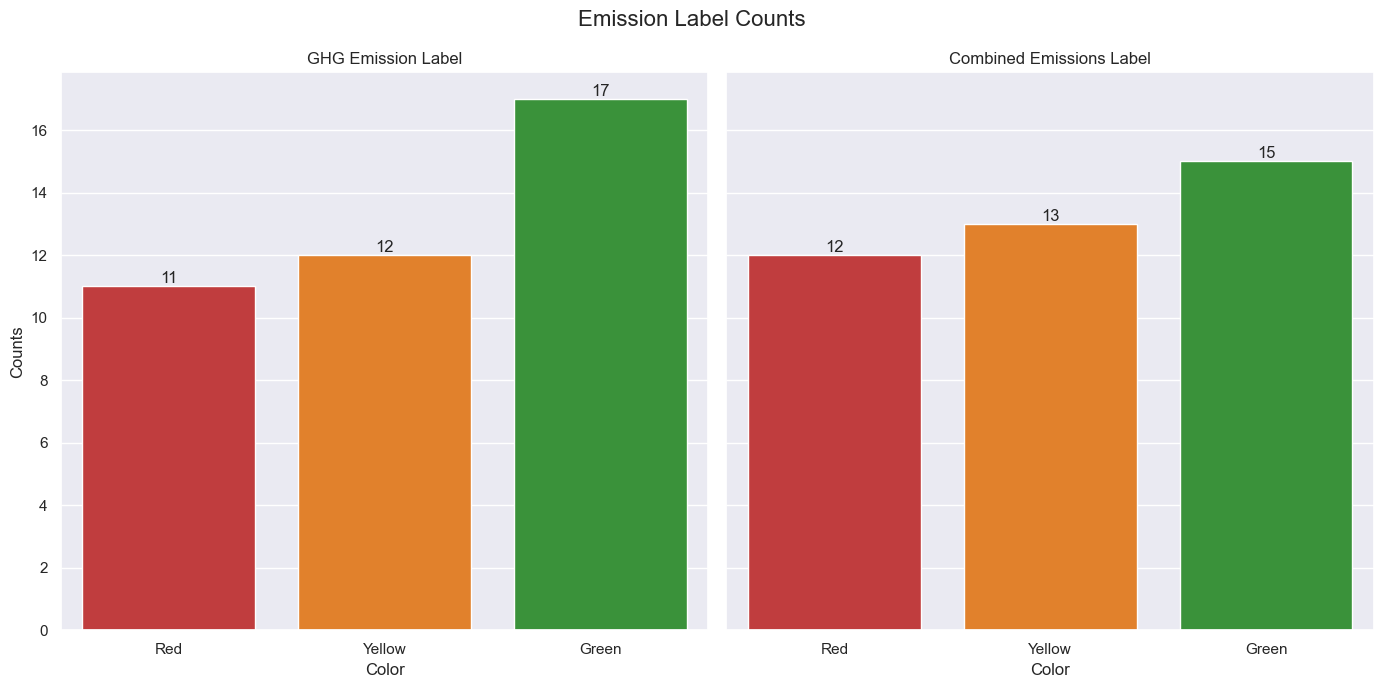

In [26]:
# THE BLUE BAR REPRESENTS THE SUM ROW WHICH IS THE TOTAL NUMBER OF RECIPES THAT HAVE BEEN ASSIGNED A LABEL
# EACH BAR REPRESENTS THE # OF RECIPES THAT WERE LABELLED WITH THAT SPECIFIC COLOUR

print(counts.columns)
fig = create_visualizations(counts)
fig

In [ ]:
fig

In [ ]:
final2.head()

,Category,Displayed Name,ProdId,Description,SalesGroup,Weight (g),GHG Emission (g),N lost (g),Land Use (m^2),Freshwater Withdrawals (L),Stress-Weighted Water Use (L),GHG Emission (g) / 100g,N lost (g) / 100g,Freshwater Withdrawals (L) / 100g,Stress-Weighted Water Use (L) / 100g,Land Use (m^2) / 100g,GHG Only Label,Combined Label
0,2024S Beets Salad,,R-7227,2024S Beets Salad,Y,384.0000,647.093720,6.353698,1.297368,76.34,4117.10,168.51,1.65,19.88,1072.16,0.34,Green,Yellow
1,2024S Blackend Chick Carbonara,,R-5554,2024S Blackend Chick Carbonara,Y,624.8420,15897.638562,157.276942,48.412277,3918.22,122763.85,2544.27,25.17,627.07,19647.18,7.75,Red,Red
2,2024S Chicken Caesar (Wrap),,R-8990,2024S Chicken Caesar (Wrap),Y,433.5900,1483.221954,24.299566,3.905403,169.68,5072.55,342.08,5.60,39.13,1169.90,0.90,Yellow,Red
3,2024S Chicken Pesto Penne,,R-8428,2024S Chicken Pesto Penne,Y,641.9335,6004.237167,111.410988,14.238672,614.05,21002.12,935.34,17.36,95.66,3271.70,2.22,Red,Red
4,2024S Chicken Po'Boy,,R-10589,2024S Chicken Po'Boy,Y,873.5233,1769.742083,33.144580,4.776946,180.24,3997.05,202.60,3.79,20.63,457.58,0.55,Yellow,Yellow


In [ ]:
final3 = final2.drop(columns=['Category', 'Displayed Name', 'Weight (g)', 'GHG Only Label'])

In [ ]:
final3.head()

,ProdId,Description,SalesGroup,GHG Emission (g),N lost (g),Land Use (m^2),Freshwater Withdrawals (L),Stress-Weighted Water Use (L),GHG Emission (g) / 100g,N lost (g) / 100g,Freshwater Withdrawals (L) / 100g,Stress-Weighted Water Use (L) / 100g,Land Use (m^2) / 100g,Combined Label
0,R-7227,2024S Beets Salad,Y,647.093720,6.353698,1.297368,76.34,4117.10,168.51,1.65,19.88,1072.16,0.34,Yellow
1,R-5554,2024S Blackend Chick Carbonara,Y,15897.638562,157.276942,48.412277,3918.22,122763.85,2544.27,25.17,627.07,19647.18,7.75,Red
2,R-8990,2024S Chicken Caesar (Wrap),Y,1483.221954,24.299566,3.905403,169.68,5072.55,342.08,5.60,39.13,1169.90,0.90,Red
3,R-8428,2024S Chicken Pesto Penne,Y,6004.237167,111.410988,14.238672,614.05,21002.12,935.34,17.36,95.66,3271.70,2.22,Red
4,R-10589,2024S Chicken Po'Boy,Y,1769.742083,33.144580,4.776946,180.24,3997.05,202.60,3.79,20.63,457.58,0.55,Yellow


In [ ]:
final3.rename(columns={'ProdId': 'Optimum Control ID', 'Description': 'OC Description'}, inplace=True)

In [ ]:
final3.head()

,Optimum Control ID,OC Description,SalesGroup,GHG Emission (g),N lost (g),Land Use (m^2),Freshwater Withdrawals (L),Stress-Weighted Water Use (L),GHG Emission (g) / 100g,N lost (g) / 100g,Freshwater Withdrawals (L) / 100g,Stress-Weighted Water Use (L) / 100g,Land Use (m^2) / 100g,Combined Label
0,R-7227,2024S Beets Salad,Y,647.093720,6.353698,1.297368,76.34,4117.10,168.51,1.65,19.88,1072.16,0.34,Yellow
1,R-5554,2024S Blackend Chick Carbonara,Y,15897.638562,157.276942,48.412277,3918.22,122763.85,2544.27,25.17,627.07,19647.18,7.75,Red
2,R-8990,2024S Chicken Caesar (Wrap),Y,1483.221954,24.299566,3.905403,169.68,5072.55,342.08,5.60,39.13,1169.90,0.90,Red
3,R-8428,2024S Chicken Pesto Penne,Y,6004.237167,111.410988,14.238672,614.05,21002.12,935.34,17.36,95.66,3271.70,2.22,Red
4,R-10589,2024S Chicken Po'Boy,Y,1769.742083,33.144580,4.776946,180.24,3997.05,202.60,3.79,20.63,457.58,0.55,Yellow


In [ ]:
final3['Red'] = final3['Combined Label'] == 'Red'
final3['Yellow'] = final3['Combined Label'] == 'Yellow'
final3['Green'] = final3['Combined Label'] == 'Green'

In [ ]:
final3.head()

,Optimum Control ID,OC Description,SalesGroup,GHG Emission (g),N lost (g),Land Use (m^2),Freshwater Withdrawals (L),Stress-Weighted Water Use (L),GHG Emission (g) / 100g,N lost (g) / 100g,Freshwater Withdrawals (L) / 100g,Stress-Weighted Water Use (L) / 100g,Land Use (m^2) / 100g,Combined Label,Red,Yellow,Green
0,R-7227,2024S Beets Salad,Y,647.093720,6.353698,1.297368,76.34,4117.10,168.51,1.65,19.88,1072.16,0.34,Yellow,False,True,False
1,R-5554,2024S Blackend Chick Carbonara,Y,15897.638562,157.276942,48.412277,3918.22,122763.85,2544.27,25.17,627.07,19647.18,7.75,Red,True,False,False
2,R-8990,2024S Chicken Caesar (Wrap),Y,1483.221954,24.299566,3.905403,169.68,5072.55,342.08,5.60,39.13,1169.90,0.90,Red,True,False,False
3,R-8428,2024S Chicken Pesto Penne,Y,6004.237167,111.410988,14.238672,614.05,21002.12,935.34,17.36,95.66,3271.70,2.22,Red,True,False,False
4,R-10589,2024S Chicken Po'Boy,Y,1769.742083,33.144580,4.776946,180.24,3997.05,202.60,3.79,20.63,457.58,0.55,Yellow,False,True,False


In [ ]:
desired_column_order = [
    'Optimum Control ID', 'OC Description', 'SalesGroup', 'Combined Label', 'Red', 'Yellow', 'Green',
    'GHG Emission (g)', 'N lost (g)', 'Land Use (m^2)', 'Freshwater Withdrawals (L)', 
    'Stress-Weighted Water Use (L)', 'GHG Emission (g) / 100g', 'N lost (g) / 100g', 
    'Freshwater Withdrawals (L) / 100g', 'Stress-Weighted Water Use (L) / 100g', 
    'Land Use (m^2) / 100g'
]

# Create a new DataFrame with the desired column order
data_reordered = final3[desired_column_order]

# Print the reordered DataFrame
data_reordered.head()


,Optimum Control ID,OC Description,SalesGroup,Combined Label,Red,Yellow,Green,GHG Emission (g),N lost (g),Land Use (m^2),Freshwater Withdrawals (L),Stress-Weighted Water Use (L),GHG Emission (g) / 100g,N lost (g) / 100g,Freshwater Withdrawals (L) / 100g,Stress-Weighted Water Use (L) / 100g,Land Use (m^2) / 100g
0,R-7227,2024S Beets Salad,Y,Yellow,False,True,False,647.093720,6.353698,1.297368,76.34,4117.10,168.51,1.65,19.88,1072.16,0.34
1,R-5554,2024S Blackend Chick Carbonara,Y,Red,True,False,False,15897.638562,157.276942,48.412277,3918.22,122763.85,2544.27,25.17,627.07,19647.18,7.75
2,R-8990,2024S Chicken Caesar (Wrap),Y,Red,True,False,False,1483.221954,24.299566,3.905403,169.68,5072.55,342.08,5.60,39.13,1169.90,0.90
3,R-8428,2024S Chicken Pesto Penne,Y,Red,True,False,False,6004.237167,111.410988,14.238672,614.05,21002.12,935.34,17.36,95.66,3271.70,2.22
4,R-10589,2024S Chicken Po'Boy,Y,Yellow,False,True,False,1769.742083,33.144580,4.776946,180.24,3997.05,202.60,3.79,20.63,457.58,0.55


In [ ]:
data_reordered.to_csv(os.getcwd() + "/data/final/2023_2024_CFFS_Outcomes/Labelled_Data_"+restaurant_name+"_for_nutrislice.csv",
                  index=False)